##Multivariate time series prediction from https://github.com/Rachnog/Deep-Trading/tree/master/multivariate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/melih/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Preprocessing

In [8]:
import transaction_reader as t_r

file = ('../Dataset/preprocess_outputs/port_calc_processed.csv')

WINDOW = 50
EMB_SIZE = 5
STEP = 20
FORECAST = 1
train_percentage = 0.8
val_percentage = 0.1

reader = t_r.Transaction_Reader(file)

X_train, X_test, X_val, Y_val, Y_train, Y_test = [], [], [], []
x_train_count = int(reader.total_transactions * train_percentage)
x_val_count = int(reader.total_transactions * train_percentage)
for j in range(reader.total_transactions):
    data, labels = reader.next_batch()
    for i in range(0, reader.trans_freqs[reader.current_batch], STEP):
        try:
            x_i = data[i:i+WINDOW]
            y_i = labels[i+WINDOW]
        except Exception as e:
            break
        if reader.current_batch <= x_train_count:
            X_train.append(x_i)
            Y_train.append(y_i)
        elif reader.current_batch > x_train_count and current_batch <= x_train_count + x_val_count:
            X_val.append(x_i)
            Y_val.append(y_i)
        else:
            X_test.append(x_i)
            Y_test.append(y_i)
    
X_train, X_val, X_test, Y_train, Y_val, Y_test = np.array(X_train), np.array(X_val), np.array(X_test), np.array(Y_train), np.array(Y_val), np.array(Y_test)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_val = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

((22736, 50, 5), (2471, 50, 5), (22736, 25), (2471, 25))


# Create and run model

In [9]:
no_class = Y_train.shape[1]

model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(no_class))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="multivariate.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_val, Y_val),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

model.load_weights("multivariate.hdf5")
pred = model.predict(np.array(X_test))

/home/melih/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(50, 5), padding="same", filters=16, kernel_size=4)`
  import sys
/home/melih/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", kernel_size=4, filters=8)`
  


Train on 22736 samples, validate on 2471 samples
Epoch 1/100
22736/22736 [==============================] - 12s 530us/step - loss: 2.5517 - acc: 0.2078 - val_loss: 4.8168 - val_acc: 0.1036

Epoch 00001: val_loss improved from inf to 4.81678, saving model to multivariate.hdf5
Epoch 2/100
22736/22736 [==============================] - 11s 498us/step - loss: 2.0181 - acc: 0.3443 - val_loss: 4.2730 - val_acc: 0.0656

Epoch 00002: val_loss improved from 4.81678 to 4.27301, saving model to multivariate.hdf5
Epoch 3/100
22736/22736 [==============================] - 12s 526us/step - loss: 1.8856 - acc: 0.3802 - val_loss: 2.9885 - val_acc: 0.1392

Epoch 00003: val_loss improved from 4.27301 to 2.98849, saving model to multivariate.hdf5
Epoch 4/100
22736/22736 [==============================] - 13s 566us/step - loss: 1.8193 - acc: 0.3938 - val_loss: 2.3005 - val_acc: 0.2481

Epoch 00004: val_loss improved from 2.98849 to 2.30050, saving model to multivariate.hdf5
Epoch 5/100
22736/22736 [======

22736/22736 [==============================] - 11s 491us/step - loss: 1.4135 - acc: 0.5088 - val_loss: 2.2188 - val_acc: 0.3942

Epoch 00043: val_loss did not improve
Epoch 44/100
22736/22736 [==============================] - 11s 490us/step - loss: 1.4062 - acc: 0.5114 - val_loss: 2.1889 - val_acc: 0.3990

Epoch 00044: val_loss did not improve
Epoch 45/100
22736/22736 [==============================] - 11s 486us/step - loss: 1.4055 - acc: 0.5146 - val_loss: 2.1348 - val_acc: 0.4241

Epoch 00045: val_loss did not improve
Epoch 46/100
22736/22736 [==============================] - 13s 578us/step - loss: 1.4046 - acc: 0.5099 - val_loss: 2.1730 - val_acc: 0.4253

Epoch 00046: val_loss did not improve
Epoch 47/100
22736/22736 [==============================] - 14s 625us/step - loss: 1.4033 - acc: 0.5128 - val_loss: 2.1765 - val_acc: 0.3982

Epoch 00047: val_loss did not improve
Epoch 48/100
22736/22736 [==============================] - 14s 600us/step - loss: 1.4039 - acc: 0.5107 - val_los

22736/22736 [==============================] - 12s 532us/step - loss: 1.3477 - acc: 0.5248 - val_loss: 2.1838 - val_acc: 0.4379

Epoch 00088: val_loss did not improve
Epoch 89/100
22736/22736 [==============================] - 14s 597us/step - loss: 1.3437 - acc: 0.5329 - val_loss: 2.2186 - val_acc: 0.4278

Epoch 00089: val_loss did not improve
Epoch 90/100
22736/22736 [==============================] - 15s 657us/step - loss: 1.3336 - acc: 0.5338 - val_loss: 2.2580 - val_acc: 0.4237

Epoch 00090: val_loss did not improve
Epoch 91/100
22736/22736 [==============================] - 14s 604us/step - loss: 1.3443 - acc: 0.5335 - val_loss: 2.1946 - val_acc: 0.4176

Epoch 00091: val_loss did not improve
Epoch 92/100
22736/22736 [==============================] - 15s 665us/step - loss: 1.3361 - acc: 0.5384 - val_loss: 2.1736 - val_acc: 0.4294

Epoch 00092: val_loss did not improve
Epoch 93/100
22736/22736 [==============================] - 14s 601us/step - loss: 1.3283 - acc: 0.5376 - val_los

# Results

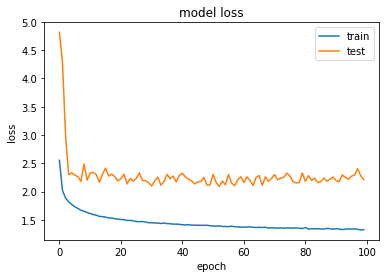

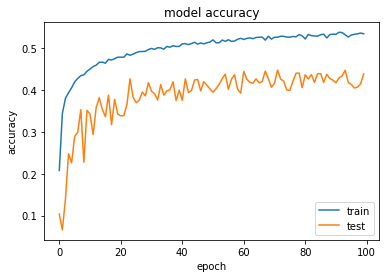

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])


# for i in range(len(pred)):
#     print Y_test[i], pred[i]


plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()